In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'intel-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111880%2F269359%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T085953Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e8f7e527acdc22ad460443fc3ddbf46082971318c65d3effbdf286b87d2bc1a14ab4fbb793293f9c36d5c771c2d93bd1be6328699d5a9ba6d34016b9e348a583733906605d51fe6eb4db20a344f14614361b46ef90ca35b358bcbb1e49d5f980f2075a1651016b3a9e9c2a16cd3e21d29fb41a862e21a53a8cd7e2d57fdff1aec1566a7ad93358b6a56982407f8725760fcc7fe40ab22f9429ee036f309e62ebcaac52cfe0d4977e4728187fe2994f40b75bc95981ecb7526c816564a9c077d2a9af39f3e7d626ac62b704b4ee26495e688e44d1cc203d548f6cbd2b34aa5eb442074e5f1cafc3ca3598d4191917ed93087e90b651d6c23f5c8ee7cb575200f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 363152213 bytes downloaded
Downloaded and uncompressed: intel-image-classification
Data source import complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
train_dataset_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
validation_dataset_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
test_dataset = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 256


In [ ]:

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


#### **Labeling**

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


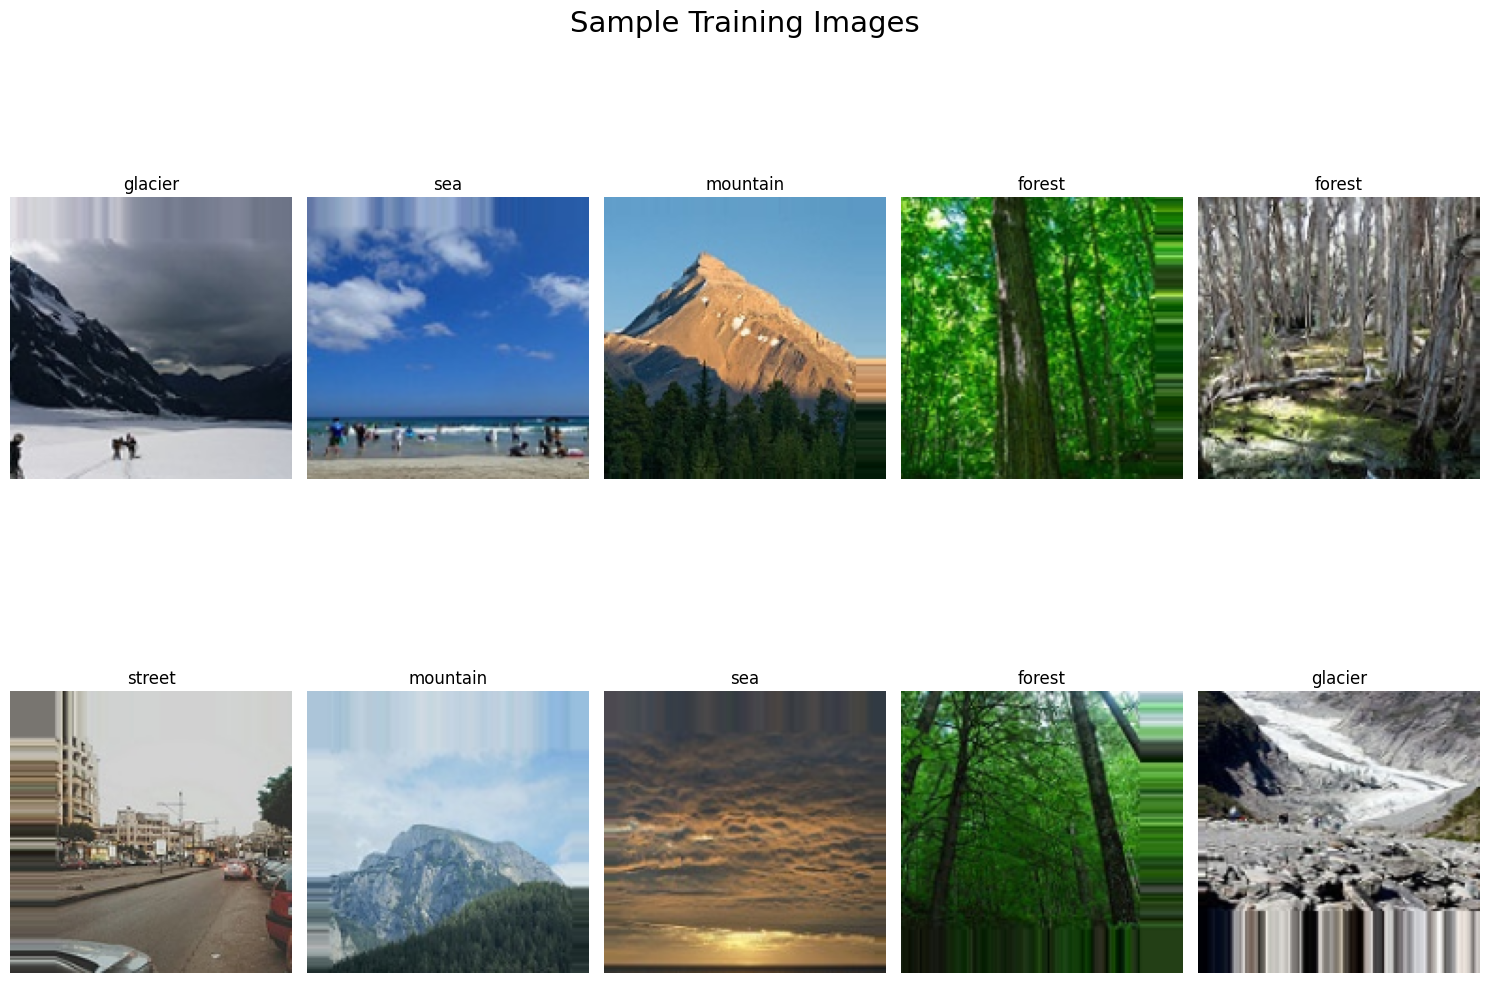

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

#### **CNN Model**

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        # filters:Number of different filters (feature detectors) that will be applied on the original image to create feature maps.
        #Dimension of the convolution filter (n x n) matrix.
        #The ReLU function is a mathematical function defined as h = max(0, a) where a (a = Wx +b) is any real number. In simpler terms, if a is less than or equal to 0, the function returns 0. Otherwise, it returns a.
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])

    return model

In [ ]:
cnn_model = create_model()

In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
optimizer = Adam(learning_rate=0.001)#Algorithm used for updating the weights of our CNN

#### **iv. Compile the Model**

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [ ]:
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       callbacks=[reduce_lr])
#An epoch is a measure of the number of times all of the training images are used once to update the weights.

Epoch 1/10
55/55 [==============================] - 117s 2s/step - loss: 1.7286 - accuracy: 0.5199 - val_loss: 2.0827 - val_accuracy: 0.2673 - lr: 0.0010
Epoch 2/10
55/55 [==============================] - 101s 2s/step - loss: 1.1587 - accuracy: 0.6295 - val_loss: 1.3733 - val_accuracy: 0.4317 - lr: 0.0010
Epoch 3/10
55/55 [==============================] - 96s 2s/step - loss: 1.0119 - accuracy: 0.6589 - val_loss: 4.2971 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 4/10
55/55 [==============================] - 95s 2s/step - loss: 0.9211 - accuracy: 0.6883 - val_loss: 3.4200 - val_accuracy: 0.2783 - lr: 0.0010
Epoch 5/10
55/55 [==============================] - 95s 2s/step - loss: 0.8024 - accuracy: 0.7200 - val_loss: 2.4700 - val_accuracy: 0.2120 - lr: 0.0010
Epoch 6/10
55/55 [==============================] - 93s 2s/step - loss: 0.7533 - accuracy: 0.7349 - val_loss: 2.5314 - val_accuracy: 0.3123 - lr: 0.0010
Epoch 7/10
55/55 [==============================] - 95s 2s/step - loss: 0.6932 -

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

### **Prediction on the Test Dataset**

In [ ]:
predictions = cnn_model.predict(test_generator)

12/12 [==============================] - 4s 354ms/step


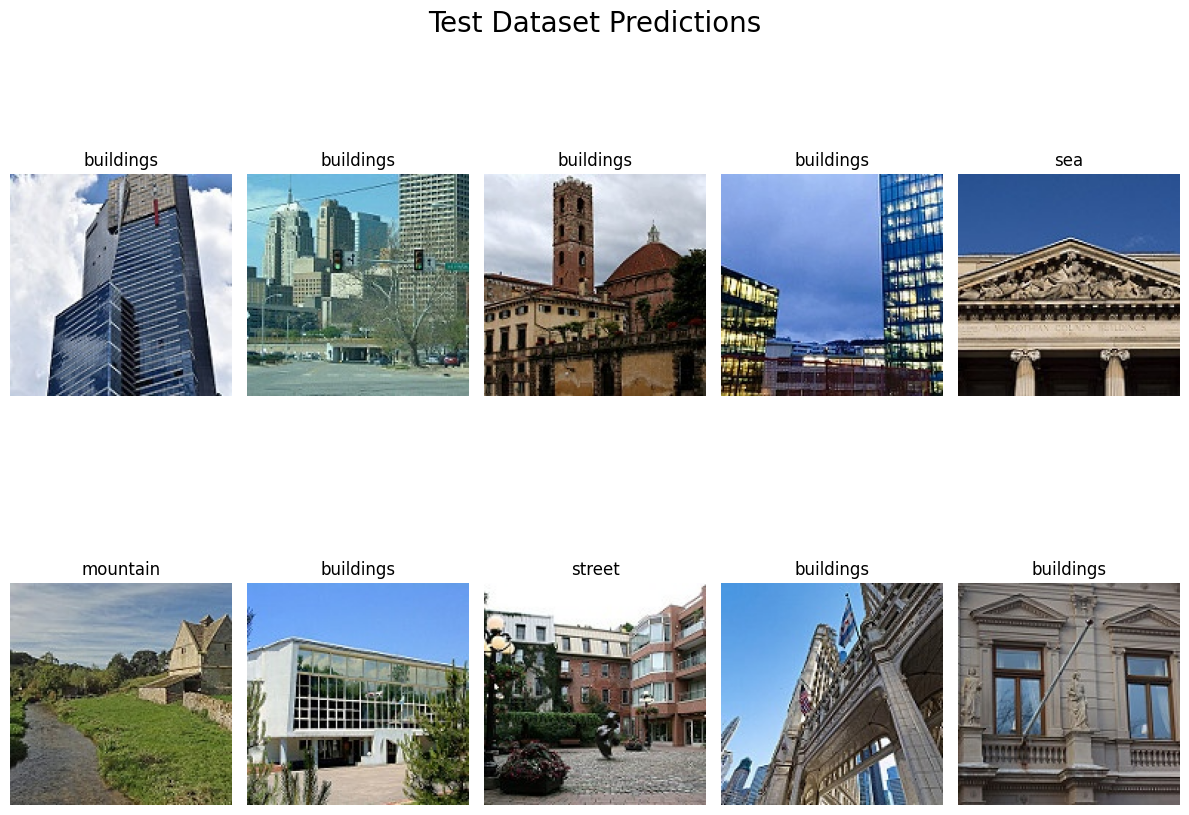

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

12/12 [==============================] - 4s 291ms/step - loss: 0.6502 - accuracy: 0.7860


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.6501710414886475
Test Accuracy: 0.7860000133514404


### **Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

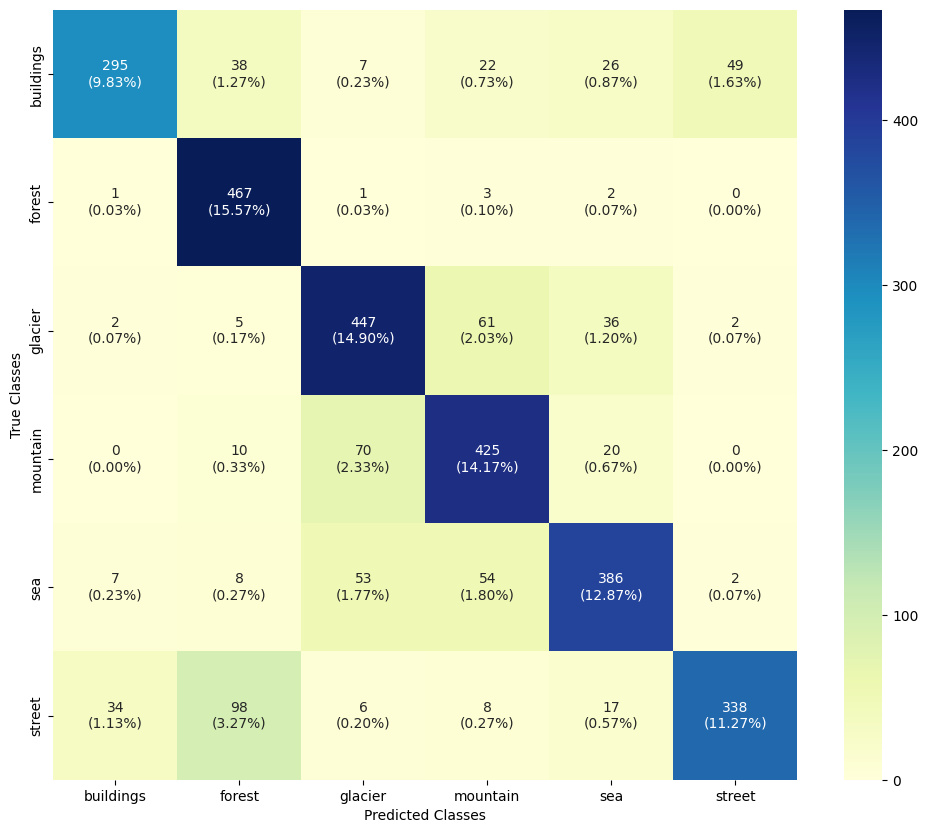

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.87      0.68      0.76       437
      forest       0.75      0.99      0.85       474
     glacier       0.77      0.81      0.79       553
    mountain       0.74      0.81      0.77       525
         sea       0.79      0.76      0.77       510
      street       0.86      0.67      0.76       501

    accuracy                           0.79      3000
   macro avg       0.80      0.78      0.78      3000
weighted avg       0.79      0.79      0.78      3000



### **Wrong Predictions**

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

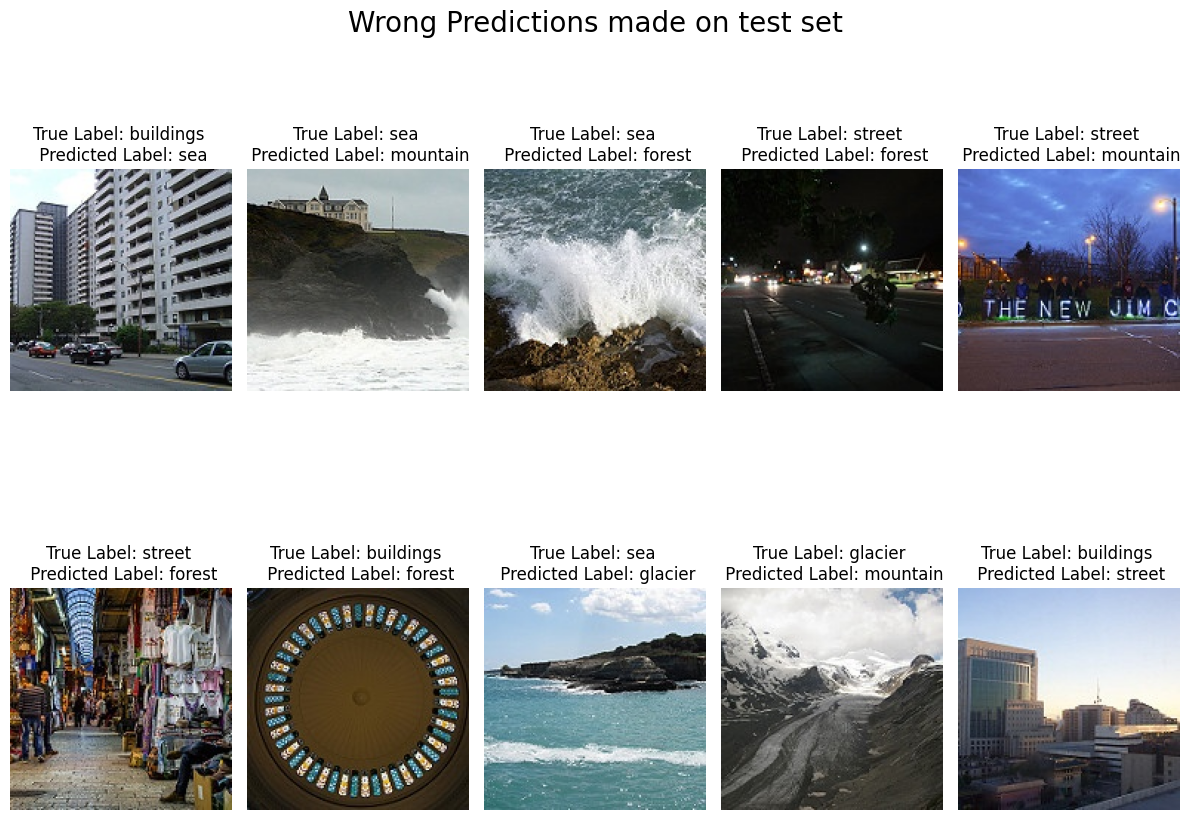

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()